## Installs / Imports

In [ ]:
# Installs

!pip install --no-index --find-links=/kaggle/input/latest-mdc-whls/whls pymupdf transformers accelerate

In [21]:
# Imports

import os 
from pathlib import Path
import re
from collections import Counter
import nltk

import pandas as pd
import numpy as np

# PDF parsing
import fitz

# plotting
import matplotlib.pyplot as plt

# Sentence tokenizer
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# load LLM
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from tqdm.auto import tqdm
import torch

import transformers
transformers.logging.set_verbosity_error() # hide non critical warnings 


import random

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Filepaths

In [22]:
# File paths

train_path = '/kaggle/input/make-data-count-finding-data-references/train'
train_pdf_path = '/kaggle/input/make-data-count-finding-data-references/train/PDF'
train_xml_path = '/kaggle/input/make-data-count-finding-data-references/train/XML'

train_labels_path = '/kaggle/input/make-data-count-finding-data-references/train_labels.csv'

test_path = '/kaggle/input/make-data-count-finding-data-references/test'
test_pdf_path = '/kaggle/input/make-data-count-finding-data-references/test/PDF'
test_xml_path = '/kaggle/input/make-data-count-finding-data-references/test/XML'

sample_submission_path = '/kaggle/input/make-data-count-finding-data-references/sample_submission.csv'

df_labels = pd.read_csv(train_labels_path)

## Split Training / Validation Data

In [ ]:
# Set your train PDF directory path
train_pdf_path = '/kaggle/input/make-data-count-finding-data-references/train/PDF'

# List all PDF files in the train directory
all_pdf_files = sorted([f for f in os.listdir(train_pdf_path) if f.endswith('.pdf')])

# Set random seed for reproducibility
import random
random.seed(42)

# Split: 80% train, 20% validation (adjust as needed)
val_percent = 0.2
n_val = int(len(all_pdf_files) * val_percent)
val_pdf_files = set(random.sample(all_pdf_files, n_val))
train_pdf_files = [f for f in all_pdf_files if f not in val_pdf_files]

print(f"Total PDFs: {len(all_pdf_files)}")
print(f"Train PDFs: {len(train_pdf_files)}")
print(f"Validation PDFs: {len(val_pdf_files)}")

# Optional: Save to files for consistency in future runs
with open("val_pdf_files.txt", "w") as f:
    for fname in sorted(val_pdf_files):
        f.write(f"{fname}\n")
with open("train_pdf_files.txt", "w") as f:
    for fname in sorted(train_pdf_files):
        f.write(f"{fname}\n")



# train + validate labels
df_train_labels = df_labels[df_labels['article_id'].isin([f.replace('.pdf','') for f in train_pdf_files])].reset_index(drop=True)
df_val_labels = df_labels[df_labels['article_id'].isin([f.replace('.pdf','') for f in val_pdf_files])].reset_index(drop=True)


## Regex Extraction

In [24]:
def extract_contexts(pdf_directory, file_list, verbose=True):
    import os
    from tqdm.auto import tqdm
    import fitz  # PyMuPDF
    import re

    chunks = []
    chunks2 = []
    text_span_len = 500

    # --- BEST PRACTICE REGEX PATTERNS ---
    re_doi = re.compile(r"10\.\d{4,9}/[-._;()/:A-Z0-9]+", re.IGNORECASE)
    re_gsr = re.compile(r"GSE\d+|SR[APRX]\d+|PRJ[NAED][A-Z]?\d+|E-[A-Z]+-\d+", re.IGNORECASE)
    re_ipe = re.compile(r"IPR\d{6}|PF\d{5}|EMPIAR-\d{5}|EMD-\d{4,5}", re.IGNORECASE)
    re_c = re.compile(r"CHEMBL\d+|CVCL_[A-Z0-9]{4}|CID:\d+", re.IGNORECASE)
    re_e = re.compile(r"ENS[A-Z]{0,6}[GT]\d{11}|ENSG\d{11}", re.IGNORECASE)
    re_r = re.compile(r"N[MC]_\d+(?:\.\d+)?|rs\d+|XM_\d+|XP_\d+", re.IGNORECASE)
    re_u = re.compile(r"(?:uniprot:)?(?:[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9][A-Z][A-Z0-9]{2}[0-9])", re.IGNORECASE)
    re_g = re.compile(r"EPI(?:_ISL_)?\d+|GISAID", re.IGNORECASE)
    re_p = re.compile(r"PXD\d{6}|SAM[ND]\d+|ERR\d+|DRR\d+|MSV\d+", re.IGNORECASE)
    re_geo = re.compile(r"GDS\d+|GPL\d+|GSM\d+", re.IGNORECASE)
    re_arrayexpress = re.compile(r"E-[A-Z]+-\d+", re.IGNORECASE)

    relist = [
        re_gsr, re_ipe, re_c, re_e, re_r, re_u, re_g, re_p, re_geo, re_arrayexpress
    ]

    ids = []

    def remove_references_section(text):
        lines = text.split('\n')
        cut_index = -1
        for i in range(len(lines) - 1, max(0, int(len(lines) * 0.3)), -1):
            line = lines[i].strip()
            obvious_patterns = [
                r'^REFERENCES?$', r'^\d+\.?\s+REFERENCES?$', r'^\d+\.?\s+References?$',
                r'^References?:?$', r'^BIBLIOGRAPHY$', r'^\d+\.?\s+BIBLIOGRAPHY$',
                r'^\d+\.?\s+Bibliography$', r'^Bibliography:?$', r'^Literature\s+Cited$', r'^Works\s+Cited$'
            ]
            if any(re.match(pattern, line, re.IGNORECASE) for pattern in obvious_patterns):
                following_lines = lines[i+1:i+4]
                has_citations = False
                for follow_line in following_lines:
                    if follow_line.strip():
                        if (re.search(r'\(\d{4}\)', follow_line)
                            or re.search(r'\d{4}\.', follow_line)
                            or 'doi:' in follow_line.lower()
                            or ' et al' in follow_line.lower()):
                            has_citations = True
                            break
                if has_citations or i >= len(lines) - 3:
                    cut_index = i
                    break
        if cut_index != -1:
            return '\n'.join(lines[:cut_index]).strip()
        return text.strip()

    empty_or_error_pdfs = 0
    short_text_pdfs = 0
    total_files = 0

    if verbose:
        print(f"Found {len(file_list)} PDF files in directory:")
        for fn in file_list:
            print(f"  {fn}")

    for filename in tqdm(file_list, total=len(file_list)):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(pdf_directory, filename)
            article_id = filename.split(".pdf")[0]
            total_files += 1

            try:
                doc = fitz.open(pdf_path)
                n_pages = len(doc)
                text = ""
                for page in doc:
                    page_text = page.get_text()
                    text += page_text + "\n"
                doc.close()
                if verbose:
                    print(f"{filename}: {n_pages} pages, {len(text)} chars")
            except Exception as e:
                if verbose:
                    print(f"Could not process {filename}: {e}")
                empty_or_error_pdfs += 1
                continue

            if len(text.strip()) < 800:
                short_text_pdfs += 1
                if verbose:
                    print(f"  [{filename}] WARNING: very short text: {len(text)} chars")
                    print(f"  Sample: {text[:200]}")
            text = remove_references_section(text)

            doi_chunk_count = 0
            doi_matches = re_doi.finditer(text)
            for match in doi_matches:
                if match.group() in article_id: continue
                doi_chunk_count += 1
                chunk = text[max(0, match.start() - text_span_len): match.start() + text_span_len]
                chunks.append((article_id, chunk))
            if verbose:
                print(f"  -> Found {doi_chunk_count} DOI matches (before filtering).")

            acc_chunk_count = 0
            for rr in relist:
                matches = rr.finditer(text)
                for match in matches:
                    ids.append(match.group())
                    acc_chunk_count += 1
                    chunk = text[max(0, match.start() - text_span_len): match.start() + text_span_len]
                    chunks2.append((article_id, chunk))
            if verbose:
                print(f"  -> Found {acc_chunk_count} accession/other ID matches.")

    if verbose:
        print("="*60)
        print(f"DOI chunks (contexts): {len(chunks)}")
        print(f"Accession/other ID chunks: {len(chunks2)}")
        print(f"Skipped or errored PDFs: {empty_or_error_pdfs}")
        print(f"Short (<800 chars) but readable PDFs: {short_text_pdfs}")
        print(f"Total processed PDFs: {total_files}")
        print("="*60)
        if len(chunks):
            print("Sample DOI extraction chunk (first 1):\n", chunks[0])
        if len(chunks2):
            print("Sample accession extraction chunk (first 1):\n", chunks2[0])

    return chunks, chunks2


In [25]:
# After your splitting code:

train_chunks, train_chunks2 = extract_contexts(train_pdf_path, train_pdf_files, verbose=False)
val_chunks, val_chunks2 = extract_contexts(train_pdf_path, list(val_pdf_files), verbose=False)


  0%|          | 0/420 [00:00<?, ?it/s]

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: uns

  0%|          | 0/104 [00:00<?, ?it/s]


[Cell 1 DIAGNOSTICS] (TRAIN) Chunks extracted: 4901
[Cell 1 DIAGNOSTICS] (TRAIN) Other ID (accession) chunks: 2321
[Cell 1 DIAGNOSTICS] (TRAIN) Sample extracted chunk:
  Article: 10.1002_2017jc013030 | Context preview: RESEARCH ARTICLE
10.1002/2017JC013030
Assessing the Variability in the Relationship Between the
Part...
  Article: 10.1002_2017jc013030 | Context preview: ing Information S2
 Supporting Information S3
 Table S1
 Table S2
 Table S3
Correspondence to:
M...
  Article: 10.1002_2017jc013030 | Context preview: s (Table 1), fol-
lowing the bioregions presented in Organelli et al. (2017a), except for the Easter...
  Article: 10.1002_2017jc013030 | Context preview: 
2
North Atlantic Western Subtropical Gyre
WNASTG
12
2
South Atlantic South Subtropical Gyre
SSASTG
...
  Article: 10.1002_2017jc013030 | Context preview: -Chla relationship. Overall, those minor changes have little impact on the
Figure 1. Geographical lo...

[Cell 1 DIAGNOSTICS] (TRAIN) Using 4901 random chunks f

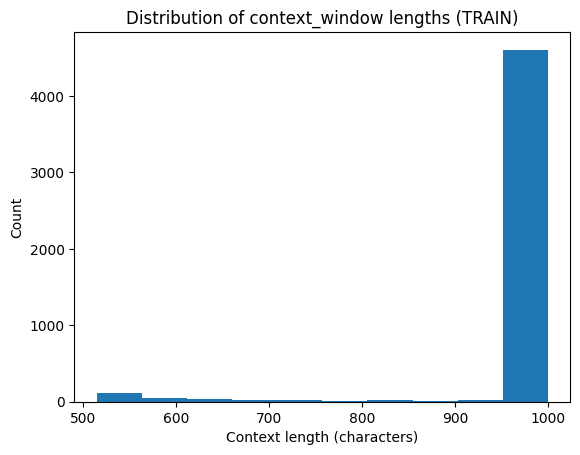

[Cell 1 DIAGNOSTICS] (TRAIN) Duplicate (article_id, context) pairs in train_chunks: 0


In [26]:
# --------- DIAGNOSTICS: Cell 1 (Context Extraction -- Training Data) ---------


print(f"\n[Cell 1 DIAGNOSTICS] (TRAIN) Chunks extracted: {len(train_chunks)}")
print(f"[Cell 1 DIAGNOSTICS] (TRAIN) Other ID (accession) chunks: {len(train_chunks2)}")

if len(train_chunks) >= 5:
    print("[Cell 1 DIAGNOSTICS] (TRAIN) Sample extracted chunk:")
    for i in range(5):
        print(f"  Article: {train_chunks[i][0]} | Context preview: {train_chunks[i][1][:100]}...")

print(f"\n[Cell 1 DIAGNOSTICS] (TRAIN) Using {len(train_chunks)} random chunks from {len(train_chunks)} total (chunks).")

# Histogram of context lengths
lens = [len(c[1]) for c in train_chunks]
if lens:
    print(f"[Cell 1 DIAGNOSTICS] (TRAIN) Context window length stats: min={min(lens)}, max={max(lens)}, mean={sum(lens)/len(lens):.1f}")
    plt.hist(lens, bins=10)
    plt.title("Distribution of context_window lengths (TRAIN)")
    plt.xlabel("Context length (characters)")
    plt.ylabel("Count")
    plt.show()
else:
    print("[Cell 1 DIAGNOSTICS] (TRAIN) No context window lengths available.")

# Duplicated chunk check
dups = len(train_chunks) - len(set([str(x) for x in train_chunks]))
print(f"[Cell 1 DIAGNOSTICS] (TRAIN) Duplicate (article_id, context) pairs in train_chunks: {dups}")


## Load LLM

In [27]:
# Load LLM

from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_PATH = "/kaggle/input/qwen2/transformers/qwen2-1.5b-instruct/1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    device_map="auto",
    torch_dtype="auto",
    local_files_only=True
)


## LLM Extract DOIs

In [28]:
def run_llm_doi_extraction(chunks, model, tokenizer, max_new_tokens=64, show_samples=5):
    """
    Run LLM DOI extraction and validation on a list of (article_id, context_window) pairs.

    Args:
        chunks: list of (article_id, context_window) tuples.
        model: HuggingFace (or similar) LLM.
        tokenizer: LLM tokenizer.
        max_new_tokens: LLM output cap.
        show_samples: Number of diagnostic printouts.
    Returns:
        prompts: list of string prompts sent to model.
        responses: list of model outputs.
    """
    SYS_PROMPT_DOI = """
You are an expert at identifying research data citations in academic papers.
Your task is to determine if a DOI citation in the given text refers specifically to research data, datasets, or data repositories.
Only respond with either a full normalized DOI URL starting with "https://doi.org/" or the word "Irrelevant" (without quotes).
Do NOT include any other text or explanation.
If there is no DOI related to research data, respond with exactly "Irrelevant".
If multiple DOIs refer to research data, return any one of them.
"""

    llm_prompts = []
    for article_id, context_window in chunks:
        messages = [
            {"role": "system", "content": SYS_PROMPT_DOI},
            {"role": "user", "content": context_window}
        ]
        prompt = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False,
        )
        llm_prompts.append(prompt)

    responses = []
    for prompt in tqdm(llm_prompts, desc="DOI LLM extraction"):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id
            )
        generated = output_ids[0][inputs["input_ids"].shape[1]:]
        response = tokenizer.decode(generated, skip_special_tokens=True).strip()
        responses.append(response)

    # Print a few sample outputs for inspection
    for idx, ((article_id, context), resp) in enumerate(zip(chunks, responses[:show_samples])):
        print(f"\nSAMPLE {idx+1}")
        print("Article:", article_id)
        print("Response:", resp)
        print("-" * 40)

    return llm_prompts, responses


In [ ]:
# For training set
train_prompts, train_llm_responses = run_llm_doi_extraction(train_chunks, model, tokenizer)

# For validation set
val_prompts, val_llm_responses = run_llm_doi_extraction(val_chunks, model, tokenizer)


# --- Token length diagnostics ---
def check_prompt_token_lengths(prompts, tokenizer, label=""):
    prompt_lengths = [len(tokenizer(p)["input_ids"]) for p in prompts]
    print(f"{label} prompts: token length stats - min {min(prompt_lengths)}, max {max(prompt_lengths)}, mean {sum(prompt_lengths)//len(prompt_lengths)}")
    print(f"Model/tokenizer max input length: {tokenizer.model_max_length}")
    if max(prompt_lengths) > tokenizer.model_max_length:
        print(f"WARNING: Some {label} prompts exceed the model's max input length and will be truncated!")
    else:
        print(f"All {label} prompts fit within model input limits.")

check_prompt_token_lengths(train_prompts, tokenizer, label="Train")
check_prompt_token_lengths(val_prompts, tokenizer, label="Val")

DOI LLM extraction:   0%|          | 0/4901 [00:00<?, ?it/s]

In [ ]:
# --------- DIAGNOSTICS: Cell 2 (LLM Extraction -- Training Data) ---------

responses = train_llm_responses    # LLM responses for training data
chunks = train_chunks              # Contexts/chunks used for LLM extraction

# Irrelevant or empty responses
irrelevant_count = sum((r.lower().strip() == "irrelevant" or r.strip() == "") for r in responses)
print(f"[Cell 2 DIAGNOSTICS] (TRAIN) Irrelevant/empty LLM responses: {irrelevant_count} / {len(responses)} ({irrelevant_count/len(responses)*100:.1f} %)")

# Multiple DOIs in one response
multi_doi = sum('10.' in r and r.strip().count('10.') > 1 for r in responses)
print(f"[Cell 2 DIAGNOSTICS] (TRAIN) LLM responses with >1 DOI string: {multi_doi} / {len(responses)}")

# Show example responses
for i in range(min(3, len(responses))):
    print(f"Article: {chunks[i][0]}\nResponse: {responses[i][:200]}\n---")


## Clean LLM DOI Responses

In [ ]:
# ------------- Cell 3: Clean LLM DOI Responses --------------

def clean_llm_doi_responses(
    chunks,                # list of (article_id, context)
    responses,             # list of LLM outputs, must match chunks order
    preprint_prefixes = ['10.1101', '10.21203'],   # can be extended/changed if needed
    show_head = 5
):
    """
    Cleans LLM DOI-extraction responses and returns a DataFrame of unique, relevant research data DOIs with context.

    Args:
        chunks: List of (article_id, context_window) tuples.
        responses: List of model outputs (same order as chunks).
        preprint_prefixes: DOIs starting with these prefixes are filtered out.
        show_head: How many rows to show with print(df.head()).

    Returns:
        pd.DataFrame with columns: article_id, dataset_id, context_window
    """

    # REGEX for DOI extraction (matches all plausible DOI forms)
    doi_regex = re.compile(r"(?:https?://(?:dx\.)?doi\.org/|doi:)?(10\.\d{4,12}/[\w.\-()/:;]+)", re.I)

    def normalize_doi(doi):
        """Return a normalized representation to compare article and dataset DOIs."""
        return doi.lower().replace('https://doi.org/','').replace('http://doi.org/','') \
            .replace('doi:','').replace('/','').replace('.','').replace('-','').replace('_','')

    def is_preprint_doi(doi):
        nd = normalize_doi(doi)
        for prefix in preprint_prefixes:
            if nd.startswith(prefix.replace('.','')):
                return True
        return False

    extracted = []
    for (article_id, context), resp in zip(chunks, responses):
        if not resp or 'irrelevant' in resp.lower() or resp.strip() == '':
            continue
        dois_found = doi_regex.findall(resp)
        for doi in dois_found:
            doi_clean = doi.strip().rstrip('.,;:!?"\' \t\n\r')
            doi_url = f"https://doi.org/{doi_clean}"
            extracted.append({
                'article_id': article_id,
                'dataset_id': doi_url,
                'context_window': context
            })

    df_dois_llm = pd.DataFrame(extracted)
    print(df_dois_llm.head(show_head))
    print(f"Extracted {len(df_dois_llm)} candidate research data DOIs with context.")

    before = len(df_dois_llm)
    mask = df_dois_llm.apply(
        lambda row: normalize_doi(row['dataset_id']) != normalize_doi(row['article_id']),
        axis=1
    )
    df_dois_llm = df_dois_llm[mask].reset_index(drop=True)
    after = len(df_dois_llm)
    print(f"[Cell 3 CLEAN] Removed {before-after} article self-DOI matches. Remaining: {after}")

    pre_before = len(df_dois_llm)
    df_dois_llm = df_dois_llm[~df_dois_llm['dataset_id'].apply(is_preprint_doi)].reset_index(drop=True)
    pre_after = len(df_dois_llm)
    print(f"[Cell 3 CLEAN] Removed {pre_before-pre_after} preprint DOIs. Remaining: {pre_after}")

    dedup_before = len(df_dois_llm)
    df_dois_llm.drop_duplicates(subset=['article_id', 'dataset_id'], inplace=True, ignore_index=True)
    print(f"[Cell 3 CLEAN] Dropped {dedup_before-len(df_dois_llm)} duplicate (article_id, dataset_id) rows.")

    print(df_dois_llm['dataset_id'].value_counts().head())
    print(f"Final cleaned DOI extraction shape: {df_dois_llm.shape}")

    return df_dois_llm


In [ ]:
df_train_dois_llm = clean_llm_doi_responses(train_chunks, train_llm_responses)
df_val_dois_llm   = clean_llm_doi_responses(val_chunks, val_llm_responses)


## LLM Classify Citations

In [ ]:
import torch
from tqdm.auto import tqdm

def classify_doi_contexts_with_llm(df_dois_llm, tokenizer, model, show_head=5):
    """
    Classifies each (DOI, context_window) row as A/B/C with an LLM, attaches results to DataFrame.

    Args:
        df_dois_llm: DataFrame with columns ['article_id', 'dataset_id', 'context_window']
        tokenizer:   Chat/instruction tokenizer for your LLM
        model:       Your LLM model
        show_head:   How many samples to print from classified DataFrame
        
    Returns:        New DataFrame with extra 'classification' column (A/B/C)
    """
    SYS_PROMPT_CLASSIFY_DOI = """
Classify the following research data citation:
A) Primary: Data was newly GENERATED or COLLECTED in THIS study (the paper in question).
B) Secondary: Data is REUSED or TAKEN from a PUBLIC database/repository, previous study, or archive.
C) None: Not research data.

If the data is from Zenodo, Dryad, PANGAEA, NCBI, EGA, SEANOE, or any public archive, or says "available at ..." or "downloaded from ...", it is almost always B.

If you are unsure, prefer B over A.

EXAMPLES:

- "The raw sequencing data generated for this study has been deposited in NCBI SRA under accession SRX123456" --> A
- "Data collected in this project are available at Zenodo DOI 10.5281/zenodo.1234567" --> A
- "All measurement data from our experiments can be found in Dryad at doi:10.5061/dryad.XXXX" --> A

- "We used the Dryad dataset in doi:10.5061/dryad.XXXX" --> B
- "The reference database PANGAEA doi:10.1594/PANGAEA.123456 was used" --> B
- "We analyzed transcriptome data from SRA accession SRX123456" --> B
- "Supplementary Table S2" --> C
- "The software package is available at github.com/myproject" --> C

Respond with ONLY one letter: A, B, or C. Do NOT explain your answer.
"""

    llm_classify_prompts = []
    for _, row in df_dois_llm.iterrows():
        messages = [
            {"role": "system", "content": SYS_PROMPT_CLASSIFY_DOI},
            {"role": "user", "content": f"DOI: {row['dataset_id']}\n\nAcademic text/context:\n{row['context_window']}\n\nOnly respond with a single letter: A, B, or C."}
        ]
        prompt = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False,
        )
        llm_classify_prompts.append(prompt)

    responses_class = []
    for prompt in tqdm(llm_classify_prompts, desc="LLM A/B/C Classification"):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=1,            # <---- CRUCIAL to get single-letter answer!
                do_sample=False,
                temperature=0.0,
                pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id
            )
        generated = output_ids[0][inputs["input_ids"].shape[1]:]
        resp = tokenizer.decode(generated, skip_special_tokens=True).strip().upper()
        # Only accept A/B/C to avoid garbage output
        if resp and resp[0] in "ABC":
            responses_class.append(resp[0])
        else:
            responses_class.append("C")
    df_out = df_dois_llm.copy()
    df_out['classification'] = responses_class

    print(df_out['classification'].value_counts())
    if show_head:
        print(df_out.head(show_head))

    return df_out


In [ ]:
# For training:
df_train_dois_llm_classified = classify_doi_contexts_with_llm(df_train_dois_llm, tokenizer, model)

# For validation:
df_val_dois_llm_classified = classify_doi_contexts_with_llm(df_val_dois_llm, tokenizer, model)


## Clean and Map LLM Responses

In [ ]:
def map_and_deduplicate_abc_df(df_classified):
    """
    Map 'classification' column ('A','B',...) to 'Primary'/'Secondary',
    drop Nones, and deduplicate by (article_id, dataset_id) favoring Primary.

    Args:
        df_classified: DataFrame with columns ['article_id', 'dataset_id', ..., 'classification']

    Returns:
        df_pred: filtered and deduplicated DataFrame, ready for submission
    """

    def map_abc(x):
        x = str(x).strip().upper()
        if x == "A":
            return "Primary"
        if x == "B":
            return "Secondary"
        return None

    df = df_classified.copy()
    df['type'] = df['classification'].apply(map_abc)
    df_pred = df[df['type'].notnull()].reset_index(drop=True)

    # Favor Primary over Secondary for each (article_id, dataset_id) pair
    df_pred = df_pred.sort_values(
        by=["article_id", "dataset_id", "type"],
        key=lambda x: x.map({"Primary": 0, "Secondary": 1}) if x.name == "type" else x
    )
    df_pred = df_pred.drop_duplicates(subset=["article_id", "dataset_id"], keep="first").reset_index(drop=True)
    return df_pred


In [ ]:
df_train_pred = map_and_deduplicate_abc_df(df_train_dois_llm_classified)
df_val_pred   = map_and_deduplicate_abc_df(df_val_dois_llm_classified)


## Validation

In [ ]:
# Remove '.pdf' if present in article_id
df_train_pred['article_id'] = df_train_pred['article_id'].astype(str).str.replace('.pdf','', regex=False)
df_val_pred['article_id'] = df_val_pred['article_id'].astype(str).str.replace('.pdf','', regex=False)
df_train_labels['article_id'] = df_train_labels['article_id'].astype(str).str.replace('.pdf','', regex=False)
df_val_labels['article_id'] = df_val_labels['article_id'].astype(str).str.replace('.pdf','', regex=False)


print("Train labels articles:", len(df_train_labels['article_id'].unique()))
print("Val labels articles:", len(df_val_labels['article_id'].unique()))

print("Unique train pred articles:", df_train_pred['article_id'].nunique())
print("Unique train label articles:", df_train_labels['article_id'].nunique())


In [ ]:
def compute_f1_scores(df_pred, df_labels, name=''):
    """
    Compute TP, FP, FN, and F1 score for a set of predictions vs. labels.
    Prints and returns stats.

    Args:
        df_pred: DataFrame with columns ['article_id', 'dataset_id', 'type']
        df_labels: DataFrame (ground truth) with columns ['article_id', 'dataset_id', 'type']
        name: Optional string to identify output (e.g. 'TRAIN', 'VAL')

    Returns:
        dict: {'tp': ..., 'fp': ..., 'fn': ..., 'f1': ...}
    """

    def f1_score(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0.0

    # Exclude "Missing" from labels
    df_labels_eval = df_labels[df_labels['type'] != 'Missing'].reset_index(drop=True)

    # Hits: intersection where article_id, dataset_id, and type all match
    hits_df = df_labels_eval.merge(df_pred, on=["article_id", "dataset_id", "type"])

    tp = hits_df.shape[0]
    fp = df_pred.shape[0] - tp
    fn = df_labels_eval.shape[0] - tp
    f1 = f1_score(tp, fp, fn)

    print(f"\n===== {name} RESULTS =====")
    print("TP:", tp)
    print("FP:", fp)
    print("FN:", fn)
    print("F1 Score:", round(f1, 3))

    return {'tp': tp, 'fp': fp, 'fn': fn, 'f1': f1}


In [ ]:
# Training set
train_scores = compute_f1_scores(df_train_pred, df_train_labels, name="TRAINING")

# Validation set
val_scores = compute_f1_scores(df_val_pred, df_val_labels, name="VALIDATION")

In [ ]:
print("Training scores:", train_scores)
print("Validation scores:", val_scores)
